In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics
import pandas as pd


# Clean up data
dump_arrival_raw = pd.read_csv('../../data/raw_data/03_Skip_deliveries_at_Mzedi.csv')


#Datetime conversion and sorting
dump_arrival_raw.date = pd.to_datetime(dump_arrival_raw.date)#.dt.tz_localize('Africa/Mbabane')
#dump_arrival_raw = dump_arrival_raw.sort_values('date')


#Delete 2010 & 2012 values
dump_arrival_raw.drop(dump_arrival_raw.loc[dump_arrival_raw.date < pd.to_datetime('2020-12-01')].index, inplace=True)
dump_arrival_raw.to_csv('../../data/interm_data/filtered_skip_deliveries_at_Mzedi.csv')

In [3]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics

numBin = 7
Q1 = 25
Q2 = 50
Q3 = 75

#Dump events & drop useless columns
dump_arrival = pd.read_csv('../../data/interm_data/filtered_skip_deliveries_at_Mzedi.csv')
dump_arrival = dump_arrival.drop(columns=['end','deviceid', 'start'])

#List of origin points
list_origin = dump_arrival.skip_origin.unique().astype(str)
list_origin = list_origin[list_origin!= 'nan']

#Datetime conversion and sorting
dump_arrival.date = pd.to_datetime(dump_arrival.date)#.dt.tz_localize('Africa/Mbabane')
dump_arrival = dump_arrival.sort_values('date')

## PIVOT TABLE
dump_arrival_new = dump_arrival.copy()
dump_arrival_new['values'] = 1
pivot_dump = pd.pivot_table(dump_arrival_new,values='values',index=['date'],columns='skip_origin',aggfunc=np.sum, fill_value=0)

print(dump_arrival.head(20))

     Unnamed: 0       date emptier type              skip_origin
120         120 2020-12-05          bcc                      NaN
103         103 2020-12-05          bcc            Bangwe market
104         104 2020-12-05          bcc           Mbayani market
105         105 2020-12-05          bcc             Limbe market
106         106 2020-12-05          bcc     Blantyre flea market
121         121 2020-12-05          bcc            Bangwe ground
112         112 2020-12-06          bcc           Kachere market
111         111 2020-12-06          bcc  Queens Guardian shelter
110         110 2020-12-06          bcc           Thawale market
108         108 2020-12-06          bcc             Limbe market
107         107 2020-12-06          bcc                      NaN
109         109 2020-12-06          bcc                      NaN
125         125 2020-12-07          bcc                 Chilobwe
124         124 2020-12-07          bcc                      NaN
123         123 2020-12-0

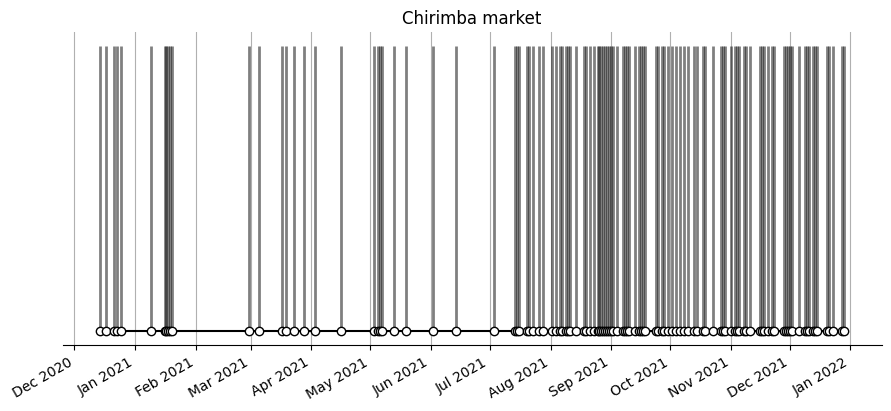

In [3]:
## TIMELINE PLOT
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)


dates_arrival_skip = pivot_dump[pivot_dump[list_origin[numBin]]!=0].index
plt.title(list_origin[numBin])

# dates_arrival_skip = pivot_dump[pivot_dump.sum(axis=1) != 0].index
# plt.title('Arrivals at Mzedi dump')

#plot timeline of dump arrivals from destination

levels = np.tile([1,1], int(np.ceil(len(dates_arrival_skip)/2)))[:len(dates_arrival_skip)] #+1,-1 stems
ax.vlines(dates_arrival_skip, 0, levels, linestyle='solid', color=[(0, 0, 0, 0.5)], linewidth=2)  # The vertical stems
ax.plot(dates_arrival_skip, np.zeros_like(dates_arrival_skip), "-o", color="k", markerfacecolor="w")  #Tick plot
ax.yaxis.set_visible(False) #Hide y axis
ax.spines[["left", "top", "right"]].set_visible(False)#Hide other lines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) #Month interval labels
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.grid(True)

plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show() #Plot

In [4]:
#Period start !!still change so that a different period time for each skip
time_start = pd.to_datetime('2021-10-01')
time_end = pd.to_datetime('2021-09-01')


## Individual skip analysis: timeline, average, max, min, pattern <-- for specific periods to match skip raw data periods

## !!ADD VARIABILITY (HISTOGRAM, VARIANCE) AS A MEASURE OF REGULARITY
## interquartile range (IQR) instead of the variance to account for outliers
##  Five Number Summary

#start,end,min, max, mean, median, mode
#period_start,period_end,min_period,max_period,median_period,mode_period
skip_dates_agg = []
current_skip_day_cum_joined= pd.DataFrame()
skip_data_stats = pd.DataFrame(np.zeros([len(list_origin),10]),
                         columns=['start','end','#','min','mean','Q1','median','Q3','max','std'], index=list_origin)
for columns in list_origin: #pivot_dump
    current_skip = pivot_dump[columns][pivot_dump[columns]!=0]
    #print(current_skip)
    list_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    current_skip_day_index= current_skip.index.dayofweek.to_list()
    current_skip_day_cum=[]
    for j in range(7):
        current_skip_day_cum.append(current_skip_day_index.count(j)) #Counts number of arrivals for each weekday
    current_skip_day_cum_joined[columns] = current_skip_day_cum
    diff_0 = (current_skip[current_skip>1]-1).sum()
    current_skip_index_diff = current_skip.index.to_series().diff().dt.days.dropna()
    listofzeros = [0] * diff_0
    zeropd = pd.DataFrame(listofzeros)#.squeeze()
    try:
        if not zeropd.empty:
            current_skip_index_diff = pd.concat([current_skip_index_diff,zeropd])
    except:
        print('except:')
        print(columns)
        print(zeropd)
        
    current_skip_index_diff = current_skip_index_diff.squeeze()
    skip_dates_agg.append(current_skip_index_diff)

    skip_data_stats.loc[columns,'start'] = current_skip.index.to_series().min()
    skip_data_stats.loc[columns,'end'] = current_skip.index.to_series().max()
    try:
        skip_data_stats.loc[columns,'#'],skip_data_stats.loc[columns,'mean'],skip_data_stats.loc[columns,'std'], skip_data_stats.loc[columns,'min'],skip_data_stats.loc[columns,'Q1'],skip_data_stats.loc[columns,'median'],skip_data_stats.loc[columns,'Q3'],skip_data_stats.loc[columns,'max']=current_skip_index_diff.describe(percentiles = [Q1/100,Q2/100,Q3/100]) 
    except:
        skip_data_stats.loc[columns,'#'] = len([current_skip_index_diff])
        skip_data_stats.loc[columns,'mean'],skip_data_stats.loc[columns,'std'], skip_data_stats.loc[columns,'min'],skip_data_stats.loc[columns,'Q1'],skip_data_stats.loc[columns,'median'],skip_data_stats.loc[columns,'Q3'],skip_data_stats.loc[columns,'max'] = [current_skip_index_diff]*7

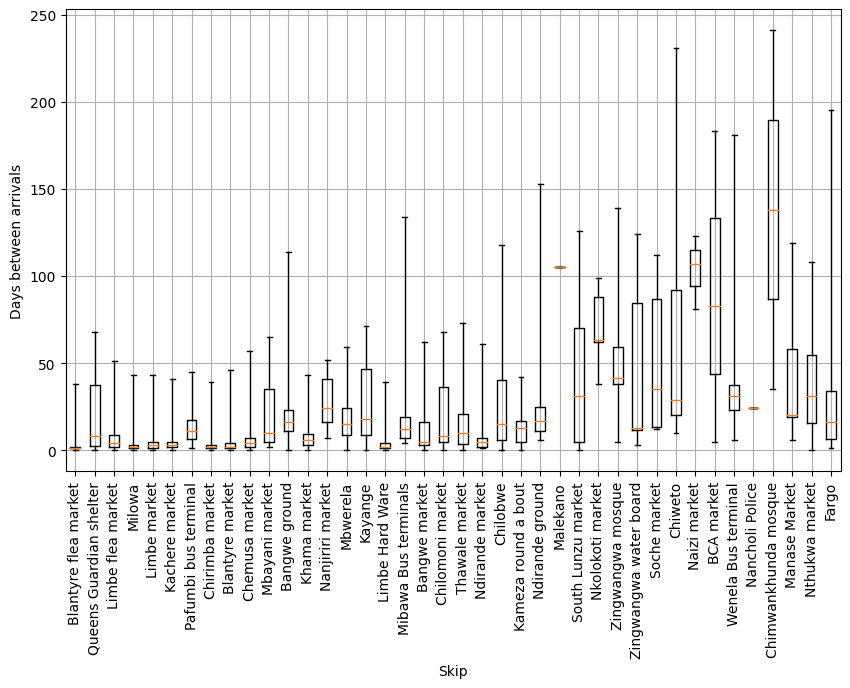

                                       start                  end      #  \
Blantyre flea market     2020-12-05 00:00:00  2021-12-30 00:00:00  205.0   
Queens Guardian shelter  2020-12-06 00:00:00  2021-11-27 00:00:00   18.0   
Limbe flea market        2020-12-07 00:00:00  2021-12-24 00:00:00   58.0   
Milowa                   2020-12-10 00:00:00  2021-12-31 00:00:00  146.0   
Limbe market             2020-12-05 00:00:00  2021-12-27 00:00:00   84.0   
Kachere market           2020-12-06 00:00:00  2021-12-28 00:00:00   73.0   
Pafumbi bus terminal     2020-12-07 00:00:00  2021-12-27 00:00:00   28.0   
Chirimba market          2020-12-14 00:00:00  2021-12-29 00:00:00  123.0   
Blantyre market          2020-12-15 00:00:00  2021-12-29 00:00:00  105.0   
Chemusa market           2020-12-11 00:00:00  2021-12-23 00:00:00   59.0   
Mbayani market           2020-12-05 00:00:00  2021-11-26 00:00:00   17.0   
Bangwe ground            2020-12-05 00:00:00  2021-12-12 00:00:00   13.0   
Khama market

In [7]:
## Box plots & print stats summary

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(skip_dates_agg, whis = 1000)
plt.xlabel('Skip')
plt.ylabel('Days between arrivals')
ax.set_xticks(np.arange(1,len(skip_data_stats.index)+1),labels=skip_data_stats.index)
plt.xticks(rotation=90)
plt.grid()
plt.show()
print(skip_data_stats)
#skip_data_stats.to_csv('../../data/interm_data/mzedi_entry_skip_data_stats.csv')

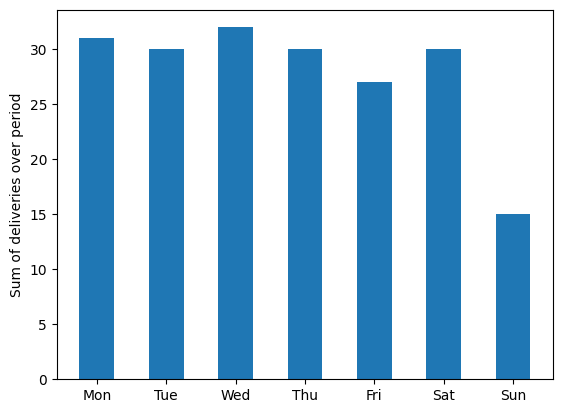

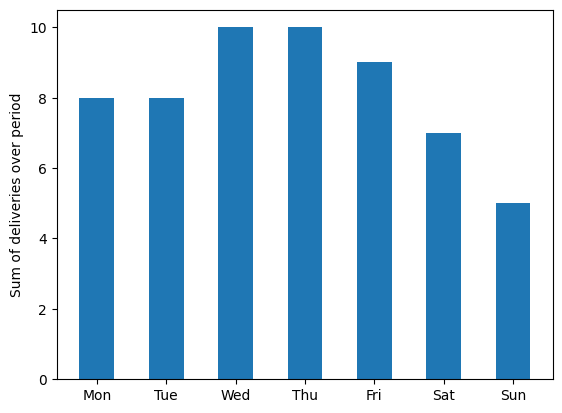

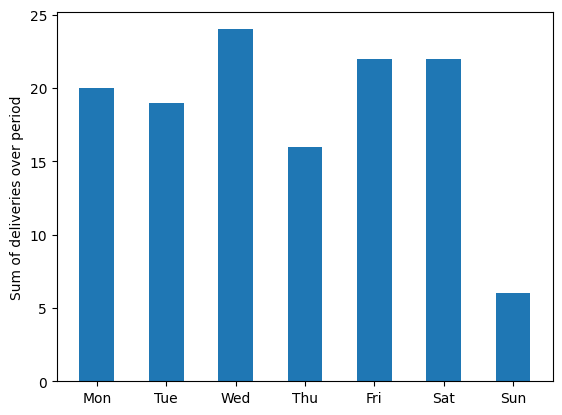

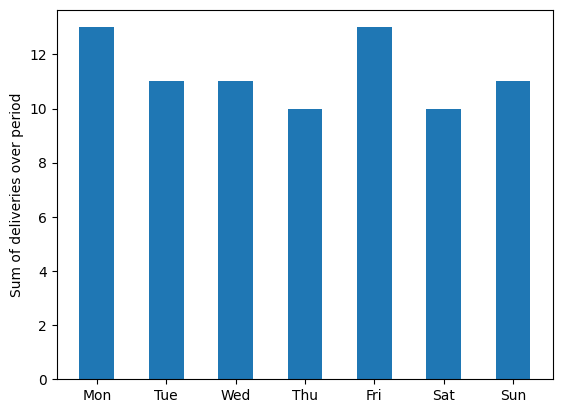

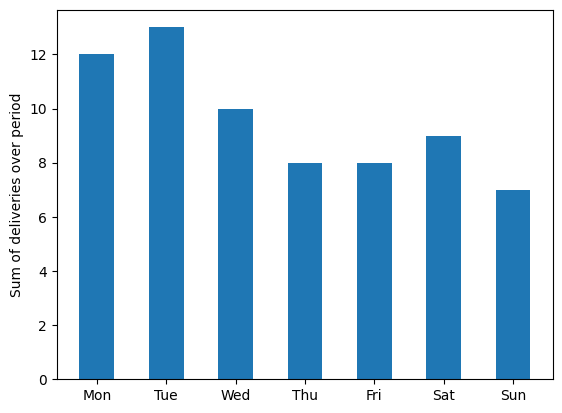

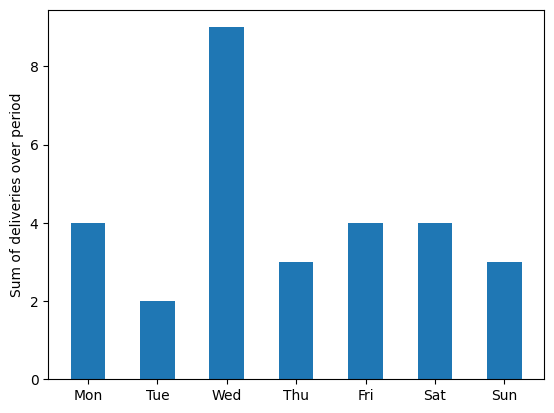

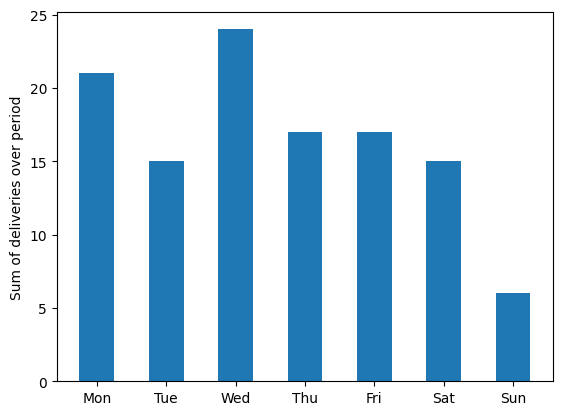

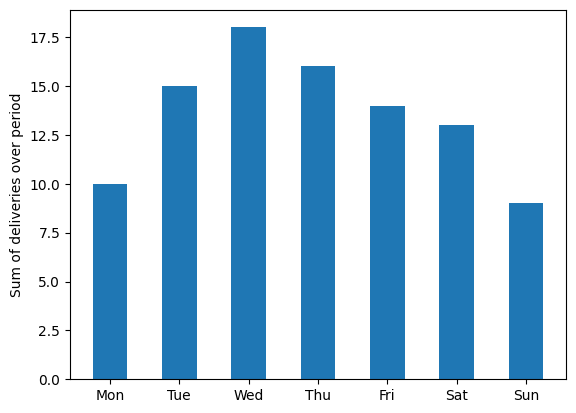

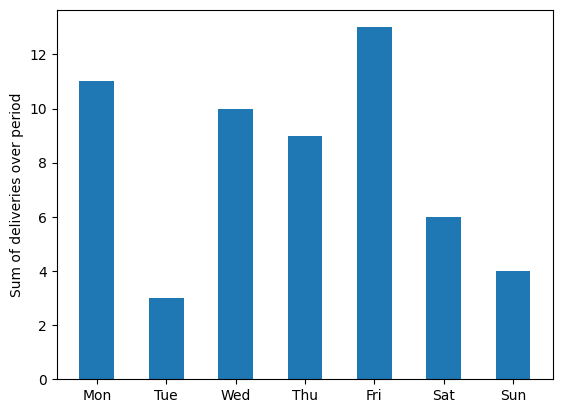

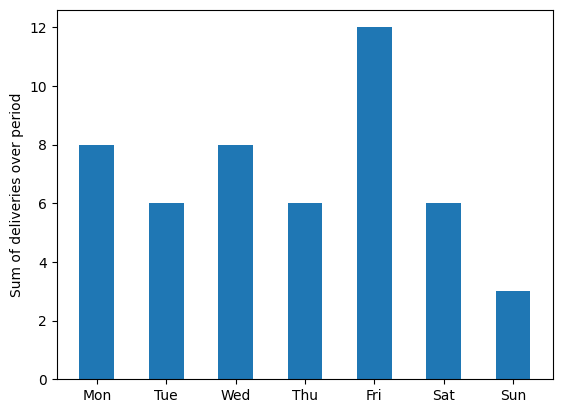

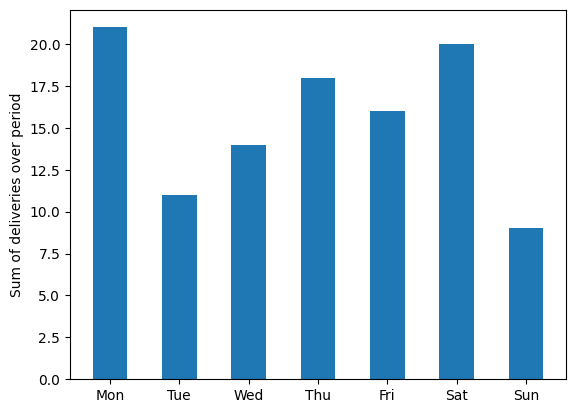

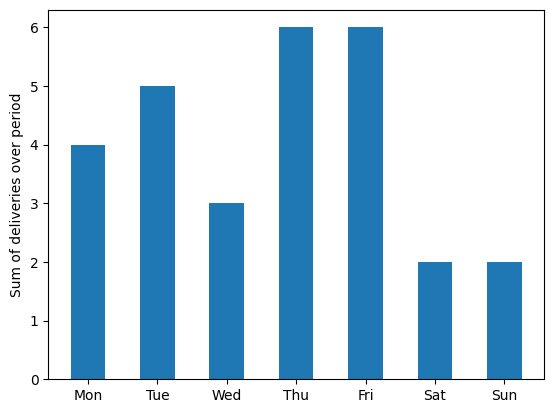

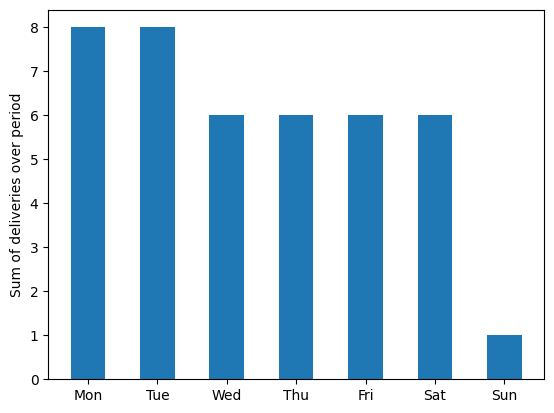

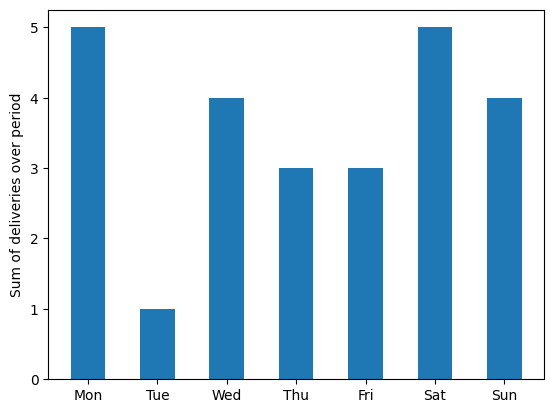

In [7]:
#Dump analysis: bar plot, pattern (week), average per week
#Correlation between day of week and incoming skip origin?
#Day of week:
list_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dump_arrival_day_index= dump_arrival.date.dt.dayofweek.to_list()
dump_arrival_day_cum=[]
for j in range(7):
    dump_arrival_day_cum.append(dump_arrival_day_index.count(j)) #Counts number of arrivals for each weekday

# fig, ax = plt.subplots()
# ax.bar(list_days, dump_arrival_day_cum)
# ax.grid()
# plt.xlabel('Day of week')
# plt.ylabel('Sum of deliveries over period')
# plt.show()

for columns in current_skip_day_cum_joined:
    if(current_skip_day_cum_joined[columns].sum()>=25):
        #print('more than 25')
        fig, ax = plt.subplots()
        plt.bar(list_days,current_skip_day_cum_joined[columns], width=0.5)
        plt.ylabel('Sum of deliveries over period')
    else:
        pass #just eliminate series with less than 25
        #print('none')
    

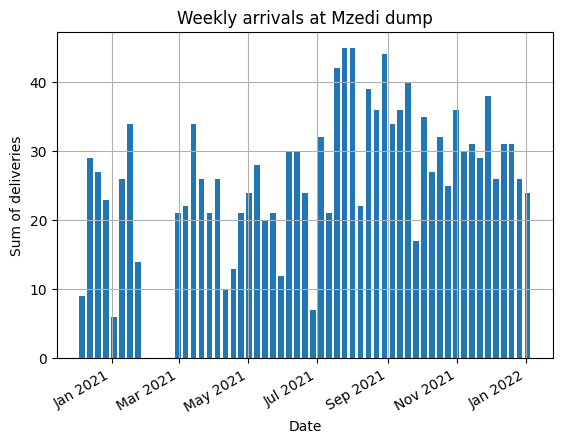

2020-12-05 00:00:00
2021-12-31 00:00:00
DatetimeIndex(['2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',
               '2021-04-25', '2021-05-02', '2021-05-09', '2021-05-16',
               '2021-05-23', '2021-05-30', '2021-06-06', '2021-06-13',
               '2021-06-20', '2021-06-27', '2021-07-04', '2021-07-11',
               '2021-07-18', '2021-07-25', '2021-08-01', '2021-08-08',
               '2021-08-15', '2021-08-22', '2021-08-29', '2021-09-05',
               '2021-09-12', '2021-09-19', '2021-09-26', '2021-10-03',
               '2021-10-10', '2021-10-17', '2021-10-24', '2021-10-31',
               '2021-11-07', '2021-11-14', '2021-11-21', '2021-11-28',
               '2021-12-05', '2021-12

In [31]:
## Weekly plot of arrivals

fig, ax = plt.subplots()
ax.bar(pivot_dump.sum(axis=1).resample('W',convention='start').sum().index,
       pivot_dump.sum(axis=1).resample('W',convention='start').sum().values, 5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Sum of deliveries')
plt.title('Weekly arrivals at Mzedi dump')
plt.savefig('figures/mzedi/weekly_arrivals.png')
plt.show()
# print(pivot_dump.sum(axis=1).index.min())
# print(pivot_dump.sum(axis=1).index.max())
# print(pivot_dump.sum(axis=1).resample('W',convention='start').sum().index, pivot_dump.sum(axis=1).resample('W',convention='start').sum().values)

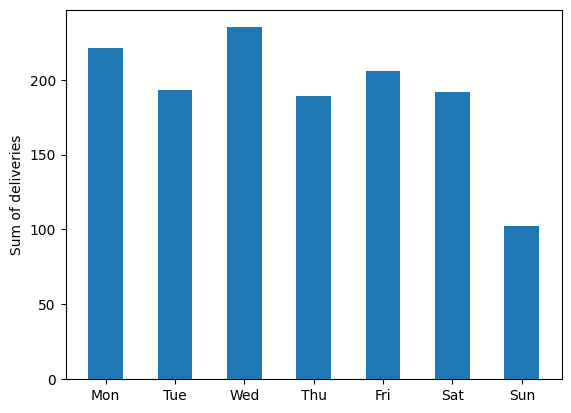

In [10]:
#Dump analysis: bar plot, pattern (week), average per week
#Day of week:
list_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dump_arrival_day_index= dump_arrival.date.dt.dayofweek.to_list()
dump_arrival_day_cum=[]
for j in range(7):
    dump_arrival_day_cum.append(dump_arrival_day_index.count(j)) #Counts number of arrivals for each weekday

# fig, ax = plt.subplots()
# ax.bar(list_days, dump_arrival_day_cum)
# ax.grid()
# plt.xlabel('Day of week')
# plt.ylabel('Sum of deliveries over period')
# plt.show()

fig,ax = plt.subplots()
plt.bar(list_days,current_skip_day_cum_joined.sum(axis=1), width=0.5)
plt.ylabel('Sum of deliveries')
plt.show()